In [2]:
# load the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.preprocessing import OneHotEncoder

In [3]:
# use pandas to make a df
base_path = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(base_path,r"data\raw\Metro_Interstate_Traffic_Volume.csv"))
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,Date,Time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,02-10-2012,09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,02-10-2012,10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,02-10-2012,11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,02-10-2012,12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,02-10-2012,13:00:00,4918


In [4]:
# missing values treatement
df.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
Date                   0
Time                   0
traffic_volume         0
dtype: int64

In [5]:
df["weather_main"].value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

In [6]:
df.holiday.value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

In [7]:
# variable transformation
# Change holiday column to be 0 if holiday else 1
df['holiday'] = [int(0) if val == 'None' else int(1) for val in df['holiday']]

#Converting temprature from unit Kelvin to Degree Celcius (for better readability)
temp_kel = df['temp']
df['temp'] = [temp_kel[i]-273.15 for i in range(len(temp_kel))]

In [8]:
#converting date into Weekdays & months
df['Day'] = pd.to_datetime(df['Date']).dt.day_of_week
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Year']  = pd.to_datetime(df['Date']).dt.year

In [9]:
# Generate feature using Feature Engingeering
# segregatting datetime in diffrent categories

df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['time_category'] = 'Other'
df.loc[(df['Time'] >= pd.to_datetime('04:00:00').time()) & (df['Time'] <= pd.to_datetime('06:59:59').time()), 'time_category'] = int(0)
df.loc[(df['Time'] >= pd.to_datetime('07:00:00').time()) & (df['Time'] <= pd.to_datetime('11:59:59').time()), 'time_category'] = int(1)
df.loc[(df['Time'] >= pd.to_datetime('12:00:00').time()) & (df['Time'] <= pd.to_datetime('15:59:59').time()), 'time_category'] = int(2)
df.loc[(df['Time'] >= pd.to_datetime('16:00:00').time()) & (df['Time'] <= pd.to_datetime('19:59:59').time()), 'time_category'] = int(3)
df.loc[(df['Time'] >= pd.to_datetime('20:00:00').time()) & (df['Time'] <= pd.to_datetime('23:59:59').time()), 'time_category'] = int(4)
df.loc[(df['Time'] >= pd.to_datetime('00:00:00').time()) & (df['Time'] <= pd.to_datetime('03:59:59').time()), 'time_category'] = int(5)

In [10]:
df["time_category"] = df.time_category.astype(int)

In [11]:
df['weather_main'].value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

In [12]:
# Merge features into categories
df['weather_main'] = df['weather_main'].replace(['Clouds', 'Haze', 'Fog', 'Smoke', 'Squall'], 'Cloudy')
df['weather_main'] = df['weather_main'].replace(['Mist', 'Drizzle', 'Rain','Snow','Thunderstorm','Squall'], 'Rainy')

In [13]:
# Outlier 
def remove_outlier(df,x):
    Q1,Q3 = np.percentile(df,[25,75])
    IQR = Q3 - Q1
    upper = np.where(df >= (Q3+1.5*IQR))
    lower = np.where(df <= (Q1-1.5*IQR))
    #Removing the Outliers
    x.drop(upper[0], inplace = True)
    x.drop(lower[0], inplace = True)

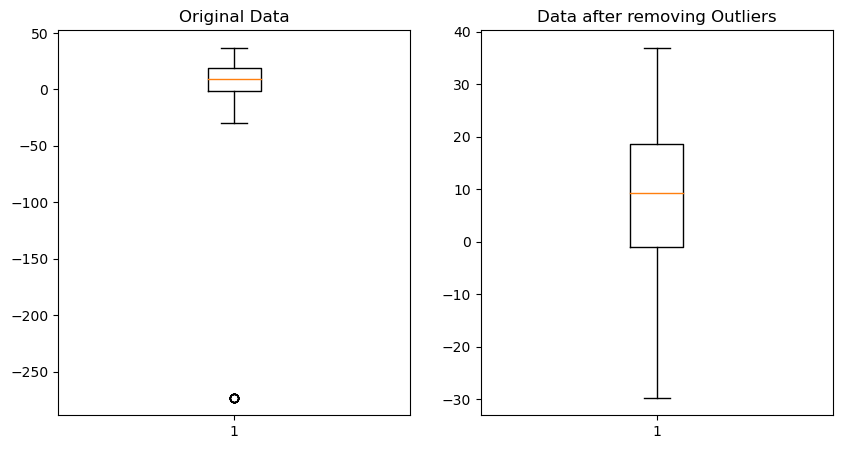

In [14]:
fig,(ax1, ax2)= plt.subplots(1, 2, figsize=(10, 5))
ax1.boxplot(df['temp'])
ax1.set_title("Original Data")

remove_outlier(df['temp'],df)
df['temp'] = df['temp'].round(2)

ax2.boxplot(df['temp'])
ax2.set_title("Data after removing Outliers")
plt.show()

In [15]:
#removing outliers
df.drop(df[df.rain_1h > 9000].index, inplace=True)

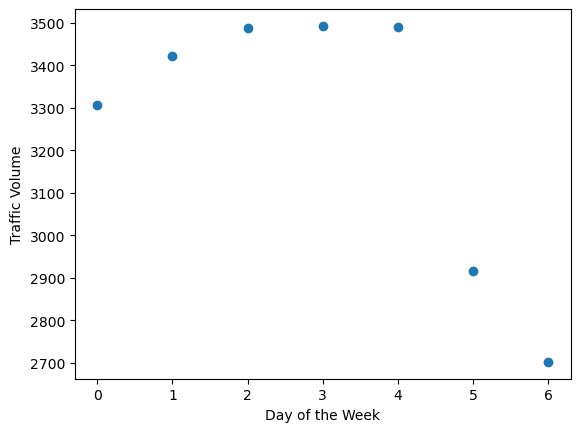

In [16]:
# scatter plot for different days of week 
# Group the data by day of the week and calculate the average traffic volume for each day
grouped_data = df.groupby("Day").mean()

# Create a scatter plot of traffic volume for each day of the week
plt.scatter(grouped_data.index, grouped_data["traffic_volume"])
plt.xlabel("Day of the Week")
plt.ylabel("Traffic Volume")
plt.show()

In [17]:
df.drop(['weather_description','Date','Time'],axis=1,inplace=True)

In [18]:
num_col = list(df.describe().columns)
cat_col = [i for i in df.columns if df[i].dtype =="object"]

In [19]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(df[cat_col]) # fit the encoder to the categorical features
# transform the categorical features to one-hot encoding
X_encoded = pd.DataFrame(encoder.transform(df[cat_col]).toarray(), columns=encoder.get_feature_names())


In [20]:
df_final = pd.concat([df, X_encoded], axis=1)
df_final.drop(columns=cat_col, axis=1, inplace=True)
df = pd.DataFrame(df_final.dropna())

In [21]:
df

,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day,Month,Year,time_category,x0_Clear,x0_Cloudy,x0_Rainy
0,0.0,15.13,0.0,0.0,40.0,5545.0,4.0,2.0,2012.0,1.0,0.0,1.0,0.0
1,0.0,16.21,0.0,0.0,75.0,4516.0,4.0,2.0,2012.0,1.0,0.0,1.0,0.0
2,0.0,16.43,0.0,0.0,90.0,4767.0,4.0,2.0,2012.0,1.0,0.0,1.0,0.0
3,0.0,16.98,0.0,0.0,90.0,5026.0,4.0,2.0,2012.0,2.0,0.0,1.0,0.0
4,0.0,17.99,0.0,0.0,75.0,4918.0,4.0,2.0,2012.0,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48188,0.0,8.23,0.0,0.0,75.0,3701.0,6.0,9.0,2018.0,1.0,0.0,1.0,0.0
48189,0.0,9.03,0.0,0.0,90.0,4049.0,6.0,9.0,2018.0,1.0,0.0,1.0,0.0
48190,0.0,9.54,0.0,0.0,75.0,4429.0,6.0,9.0,2018.0,2.0,0.0,0.0,1.0
48191,0.0,9.88,0.0,0.0,90.0,4547.0,6.0,9.0,2018.0,2.0,0.0,1.0,0.0


In [22]:
df.to_csv(os.path.join(base_path,'data\processed\Encoded_data.csv'))

In [23]:
import pickle
with open(os.path.join(base_path,'saved_models\encoder.pickle'), 'wb') as file:
    pickle.dump(encoder, file)

In [1]:
df

NameError: name 'df' is not defined